In [1]:
import tensorflow as tf
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
import seaborn as sns
import scikitplot as skplt
import sklearn
from Bio.Seq import Seq
from sklearn.metrics import classification_report
import math
np.random.seed(42)

Changes from previous version: I am only using sequences between 100-138 aa for the healthy set because that aligns with the lengths of the COVID data. I don't want the model to classify based on length.

I expect results to be slightly lower, since model may have been biased before classifying based on length

In [2]:
# Note that row 10467 of the COVID-19 sequences was deleted due to having an empty HCDR3. The total number of COVID-19 samples is now 11,867

In [3]:
tf.__version__

'2.10.0'

# Data Formatting

In [4]:
df = pd.read_csv("../Data/CoV-AbDab_031022.csv")
df = df[["VHorVHH"]]
df = df[df["VHorVHH"].apply(lambda x: len(x) <= 138)]
df = df[(df.VHorVHH != 'ND')]
df
# df = df[["CDRH3"]]

,VHorVHH
5,QITLKESGPTLVKPTQTLTLTCKLSGFSVNTGGVGVGWIRQPPGKA...
32,QVQLVQSGAEVKKPGSSVKVSCKASGDTFNIYAINWVRQAPGQGLE...
33,QVQLVQSGAEVKKPGSSVKVSCKASGGTFNSYAITWVRQAPGQGLE...
34,QVQLVESGGGVVQPGRSLRLSCAASGFTFSTHGMHWVRQAPGKGLE...
35,QVQLVQSGAEVKKPGSSVKVSCKASGGTFRRYAISWVRQAPGQGLE...
...,...
11862,EVQVVESGGGLVKPGGSLRLSCAASGFTFSSYTMNWVRQAPGKGLE...
11863,QMQLVQSGPEVKRPGTSVKVSCEASGFTFSSSAILWVRQPRGQRLE...
11864,QVQLVESGGGLVKPGGSLRLSCAASGFTFSDYYMNWIRQAPGKGLE...
11865,EVQLVESGGGLVQPGGSLRLSCAASGFTFSRFAMHWVRQAPGKGLE...


In [5]:
dummy = []
head = []
with open("../Data/cAb-rep/cAb-Rep_heavy.nt.txt") as myfile:
    # count = 0
    for i in myfile:
        # if count <= 1:
        #     print(i)
        #     if i.find(">") == -1 & i.find("-") == -1:
        #         print(Seq.translate(i.strip()))
        #     count+=1
        dummy.append(i)
    np.random.shuffle(dummy)
    
    for i in dummy:
        if i.find(">") == -1 & i.find("-") == -1 & i.find("N") == -1: # These conditions must be met for a valid sequence, the longest was 141. However, there is no 141 sequence for COVID, the greatest is 138, so we go with that
            aa_sequence = Seq.translate(i.strip())
            if (len(aa_sequence) <= 138) & (len(aa_sequence) >= 100):
                head.append(aa_sequence)
                if len(head) >= 11415:
                    break
print(head[:5], len(head))
healthy_sequences = head

/Users/joseph/miniforge3/envs/test_env/lib/python3.10/site-packages/Bio/Seq.py:3482: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


['EVQLVQSGPEVKKPGSSVKVSCKASGGTFSNFAFSWVRQAPGQGLEWMGSVILHLGTSTYAQKFQGRVTITADESTSAAFMDLNALTSDDTAVYYCARVVAVPGRVPYWFDPWGQGTLVTVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEINHSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCARVPPTSTVTTLGDDYWGQGTLVTVSS', 'QVQLVQSGPEVKKPGASVRVSCKPSGYPFSNYGISWMRQAPGQGLEWMGWVNIDKGNTKYAQKFQDRVTMTTDTSSSTVYLELRSLRSDDTALYYCARERGGYRYGDYWGQGTLVIVSS', 'TLSLTCAVYGGSFSGYYWSWIRQPPGKGLEWIGEIKHSGSTNYIPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCASRAGAAAASWGQGTLVTVSS', 'SETLSLTCAVHGGSFSDYYWTWIRQPPGKGLEWIGEINHRGGTNYNPSLKSRLNILVDTSKSQFSLKLSSVTAADTAVYFCARERFILIRGLTKYYYYMDVWGKGTTVTVS'] 11415


In [6]:
covid_sequences = df.to_numpy()
covid_sequences = np.squeeze(covid_sequences)
np.random.shuffle(covid_sequences)
# print(healthy_sequences)
print(len(max(healthy_sequences, key=len)))
print(len(max(covid_sequences, key=len)))

# print(covid_sequences)

138
138


In [7]:
# order from https://www.ncbi.nlm.nih.gov/Class/MLACourse/Modules/MolBioReview/iupac_aa_abbreviations.html

# Preprocessing

In [8]:
covid_onehot = []
healthy_onehot = []

order = "ARNDCQEGHILKMFPSTWYV"

for i in covid_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((138, 20))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    covid_onehot.append(b)

# print(covid_onehot)

unique_aa = []

for i in healthy_sequences:
    i = i.strip()
    count = 0
    b = np.zeros((138, 20))
    unique_aa = list(set(i)) + list(set(unique_aa))
    for j in i:
        b[count, order.index(j)] = 1
        count+=1
    healthy_onehot.append(b)
    
# print(set(unique_aa))

# print(healthy_onehot)

print(len(covid_onehot))

print(covid_onehot[0])

# set infected 1, healthy 0

11415
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
healthy_lables = [0] * 11415
covid_lables = [1] * 11415

In [10]:
X = np.concatenate((healthy_onehot, covid_onehot))
y = np.concatenate((healthy_lables, covid_lables))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Model

In [12]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(138, 20)),
  tf.keras.layers.Dense(2760, activation='relu'),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1536, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(4, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2022-12-10 21:30:40.110412: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-10 21:30:40.110550: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2760)              0         
                                                                 
 dense (Dense)               (None, 2760)              7620360   
                                                                 
 dense_1 (Dense)             (None, 2048)              5654528   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 1536)              3147264   
                                                                 
 dense_3 (Dense)             (None, 1024)              1573888   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, y_train, epochs=25, validation_data = (X_val, y_val))

Epoch 1/25


2022-12-10 21:30:40.614751: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-10 21:30:41.076351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - ETA: 0s - loss: 0.4690 - accuracy: 0.7517

2022-12-10 21:30:51.131724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


578/578 [==============================] - 11s 17ms/step - loss: 0.4690 - accuracy: 0.7517 - val_loss: 0.4329 - val_accuracy: 0.7922
Epoch 2/25
578/578 [==============================] - 11s 20ms/step - loss: 0.3899 - accuracy: 0.8076 - val_loss: 0.3907 - val_accuracy: 0.7917
Epoch 3/25
578/578 [==============================] - 10s 17ms/step - loss: 0.3452 - accuracy: 0.8332 - val_loss: 0.3758 - val_accuracy: 0.8161
Epoch 4/25
578/578 [==============================] - 10s 17ms/step - loss: 0.3047 - accuracy: 0.8557 - val_loss: 0.3724 - val_accuracy: 0.8273
Epoch 5/25
578/578 [==============================] - 10s 17ms/step - loss: 0.2623 - accuracy: 0.8777 - val_loss: 0.3713 - val_accuracy: 0.8170
Epoch 6/25
578/578 [==============================] - 10s 17ms/step - loss: 0.2212 - accuracy: 0.8989 - val_loss: 0.3651 - val_accuracy: 0.8316
Epoch 7/25
578/578 [==============================] - 10s 17ms/step - loss: 0.1988 - accuracy: 0.9132 - val_loss: 0.3771 - val_accuracy: 0.8350
Epo

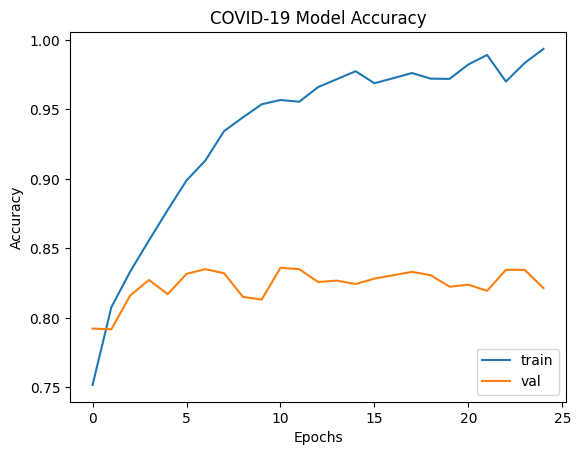

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('COVID-19 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

# Testing

In [16]:
model.evaluate(X_test, y_test)

72/72 [==============================] - 0s 6ms/step - loss: 0.8846 - accuracy: 0.8314


[0.8846330642700195, 0.831362247467041]

In [17]:
y_pred = []
y_true = y_test
# for i in X_test: print(i[:3000], "\n")

for i in X_test:
    i = np.expand_dims(i, axis=0)
    y_pred.append(np.round(model.predict(i)))

y_pred

1/1 [==============================] - 0s 16ms/step


2022-12-10 21:34:36.944959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


[array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[0.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([[1.]], dtype=float32),
 array([

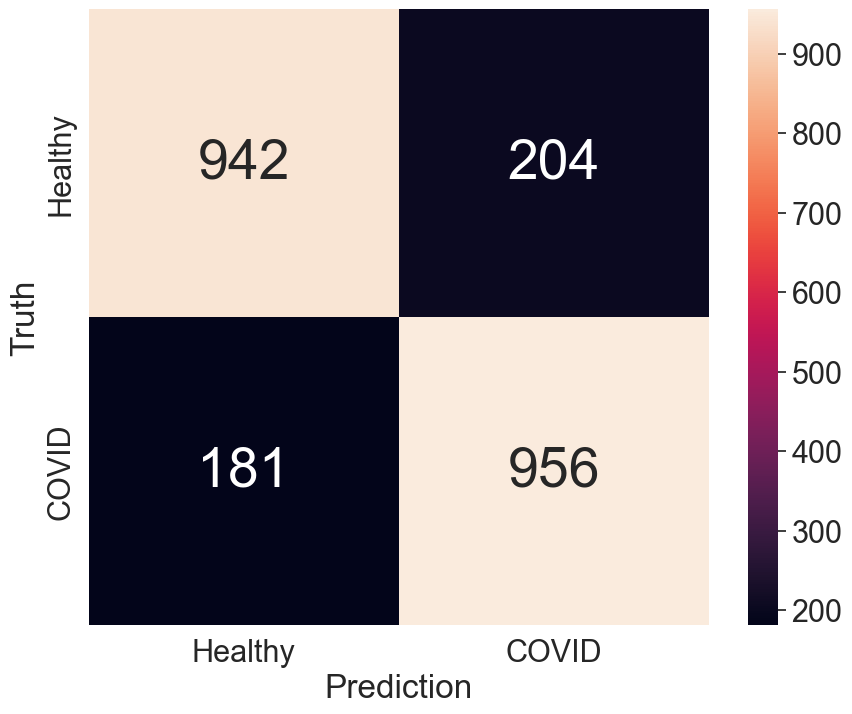

tf.Tensor(
[[942 204]
 [181 956]], shape=(2, 2), dtype=int32)


In [18]:
correct_labels = np.array(tf.concat([item for item in y_true], axis = 0))
predicted_labels = np.array(tf.concat([item for item in y_pred], axis = 0))

confusion_mtx = tf.math.confusion_matrix(correct_labels, predicted_labels)
plt.figure(figsize=(10, 8))
sns.set(font_scale=2)
sns.heatmap(confusion_mtx,
            xticklabels=["Healthy", "COVID"],
            yticklabels=["Healthy", "COVID"],
            annot=True, fmt='g', annot_kws={"size":40})
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

print(confusion_mtx)

In [19]:
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(correct_labels, predicted_labels).ravel()
print(tn, fp, fn, tp)

print(sklearn.metrics.classification_report(correct_labels, predicted_labels, digits=4))


942 204 181 956
              precision    recall  f1-score   support

           0     0.8388    0.8220    0.8303      1146
           1     0.8241    0.8408    0.8324      1137

    accuracy                         0.8314      2283
   macro avg     0.8315    0.8314    0.8314      2283
weighted avg     0.8315    0.8314    0.8314      2283



In [20]:
tf.math.confusion_matrix([0, 0, 0, 0, 0], [1, 1, 1, 1, 1]) # represents # of false positives (0 actual 1 pred)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[0, 5],
       [0, 0]], dtype=int32)>

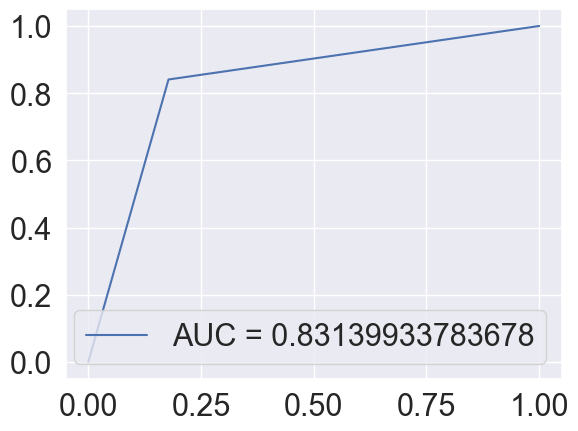

In [21]:
fpr, tpr, _ = sklearn.metrics.roc_curve(correct_labels,  predicted_labels)
auc = sklearn.metrics.roc_auc_score(correct_labels, predicted_labels)
plt.plot(fpr,tpr,label="AUC = "+str(auc))
plt.legend(loc=4)
plt.show()